In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [3]:
# Parámetros
basePath = '../data'  # Ajusta la ruta si es necesario
train_dir = os.path.join(basePath, 'preprocessed', 'train')  # Ruta para entrenar
test_dir = os.path.join(basePath, 'preprocessed', 'test')  # Ruta para test
batch_size = 64
img_size = 224
num_classes = 15
epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Cargar el modelo preentrenado y ajustarlo
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

model.classifier = nn.Sequential(
    nn.Dropout(0.1), # .3
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)

# Para entrenamiento (con augmentations)
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Para prueba/validación (sin augmentations)
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

"""#CAMBIO A ESCALA A GRISES
# Transforms para grises con 3 canales
grayscale_3c = transforms.Lambda(lambda x: x.convert("L").convert("RGB"))

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    grayscale_3c,  # escala de grises
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    grayscale_3c,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])"""

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir los objetos de pérdida y optimización
criterion = nn.CrossEntropyLoss()  # Para clasificación múltiple
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) # step_size 5 Si no es 2 es 3!!
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)


In [4]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    epoch_times = []

    print("\n🔧 Iniciando entrenamiento del modelo...\n")

    for epoch in range(epochs):
        start_time = time.time()

        # Modo entrenamiento
        model.train()
        train_loss, corrects, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = corrects / total

        # Modo evaluación
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_corrects += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / len(test_loader.dataset)
        epoch_val_acc = val_corrects / val_total

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        scheduler.step(epoch_val_acc)
        #scheduler.step()
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        # ✅ Salida clara por época
        print(f"[Época {epoch + 1:2}/{epochs}] "
              f"🟦 Train: Loss={epoch_train_loss:.4f}, Acc={epoch_train_acc:.4f} | "
              f"🟩 test: Loss={epoch_val_loss:.4f}, Acc={epoch_val_acc:.4f} | "
              f"⏱ Tiempo: {epoch_time:.1f}s")

        # Guardar el mejor modelo
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = model.state_dict()

    print(f"\n✅ Entrenamiento finalizado. Mejor precisión de validación: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history, epoch_times


In [5]:
def plot_training(history, epoch_times):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Gráfico de pérdida
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history['train_loss'], label='Entrenamiento', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validación', marker='x')
    plt.title('Pérdida del modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    # Gráfico de precisión
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history['train_acc'], label='Entrenamiento', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validación', marker='x')
    plt.title('Precisión del modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Tiempo por época (impresión simple)
    print("\n⏱ Tiempo promedio por época: {:.2f} segundos".format(sum(epoch_times)/len(epoch_times)))


GRAFICA CON SEABORN

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history):
    sns.set(style="whitegrid")
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Pérdida
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=history['train_loss'], label='Train Loss')
    sns.lineplot(x=epochs, y=history['val_loss'], label='Val Loss')
    plt.title("Curva de pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")

    # Precisión
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=history['train_acc'], label='Train Acc')
    sns.lineplot(x=epochs, y=history['val_acc'], label='Val Acc')
    plt.title("Curva de precisión")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")

    plt.tight_layout()
    plt.show()



🔧 Iniciando entrenamiento del modelo...

[Época  1/100] 🟦 Train: Loss=0.2560, Acc=0.9293 | 🟩 test: Loss=0.0240, Acc=0.9917 | ⏱ Tiempo: 11.2s
[Época  2/100] 🟦 Train: Loss=0.0121, Acc=0.9971 | 🟩 test: Loss=0.0053, Acc=1.0000 | ⏱ Tiempo: 9.7s
[Época  3/100] 🟦 Train: Loss=0.0128, Acc=0.9979 | 🟩 test: Loss=0.0059, Acc=1.0000 | ⏱ Tiempo: 9.8s
[Época  4/100] 🟦 Train: Loss=0.0029, Acc=1.0000 | 🟩 test: Loss=0.0015, Acc=1.0000 | ⏱ Tiempo: 9.9s
[Época  5/100] 🟦 Train: Loss=0.0092, Acc=0.9983 | 🟩 test: Loss=0.0142, Acc=0.9967 | ⏱ Tiempo: 10.1s
[Época  6/100] 🟦 Train: Loss=0.0015, Acc=1.0000 | 🟩 test: Loss=0.0034, Acc=0.9983 | ⏱ Tiempo: 9.8s
[Época  7/100] 🟦 Train: Loss=0.0005, Acc=1.0000 | 🟩 test: Loss=0.0013, Acc=0.9983 | ⏱ Tiempo: 10.3s
[Época  8/100] 🟦 Train: Loss=0.0004, Acc=1.0000 | 🟩 test: Loss=0.0010, Acc=1.0000 | ⏱ Tiempo: 9.8s
[Época  9/100] 🟦 Train: Loss=0.0002, Acc=1.0000 | 🟩 test: Loss=0.0008, Acc=1.0000 | ⏱ Tiempo: 10.1s
[Época 10/100] 🟦 Train: Loss=0.0002, Acc=1.0000 | 🟩 test: Loss=

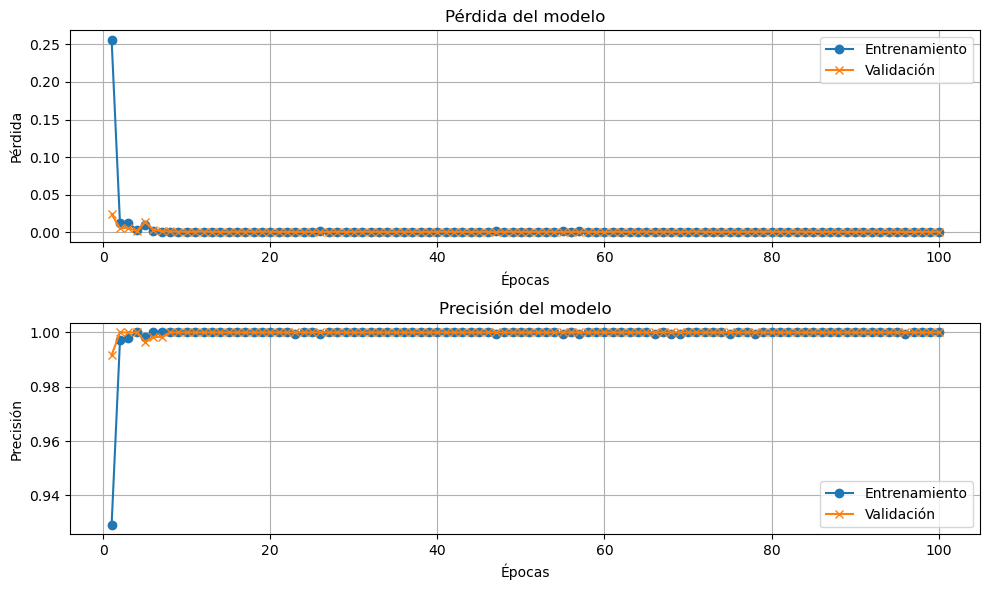


⏱ Tiempo promedio por época: 10.03 segundos


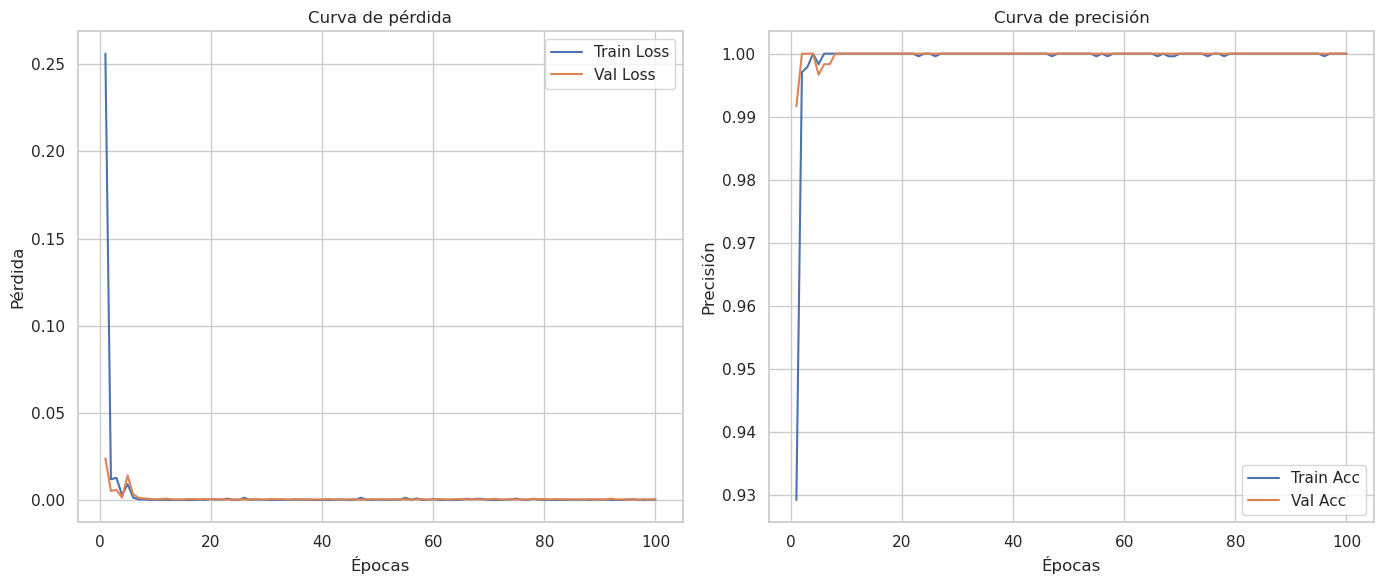

In [7]:
# Entrenar el modelo
model, history, epoch_times = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs)

# Guardar el modelo entrenado
torch.save(model.state_dict(), '../models/re_fa_15_100e_64b_gray.pth')

# Graficar los resultados
plot_training(history, epoch_times)

plot_training_history(history)